In [1]:
# import dependencies
import warnings
warnings.filterwarnings('ignore')
import pandas as pd                     
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas import Series
import requests, re
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sqlalchemy
from sqlalchemy import create_engine, func
import sqlite3 as sql

In [2]:
# load data
db = sqlalchemy.create_engine('sqlite:///movies.sqlite')
imdb_df = pd.read_sql('select * from cleaned_movies', db)
imdb_df

,field1,title,year,month,genre,duration,country,language,budget,total_gross,net_income,critic_reviews,user_reviews,metascore,meta_hit
0,4334,Kate & Leopold,2001,3,"Comedy, Fantasy, Romance",118,USA,"English, French",48000000,76019048,28019048,115.0,341.0,44.0,0
1,19759,Diritto di cronaca,1981,3,"Drama, Romance, Thriller",116,USA,"English, Spanish",12000000,40716963,28716963,27.0,115.0,64.0,0
2,19774,Arturo,1981,2,"Comedy, Romance",97,USA,English,7000000,95461682,88461682,44.0,132.0,69.0,0
3,19790,Blow Out,1981,4,"Crime, Drama, Mystery",108,USA,English,18000000,12000000,-6000000,123.0,199.0,86.0,1
4,19804,Libertà poco vigilata,1981,5,"Comedy, Drama",94,USA,English,11000000,31261269,20261269,5.0,16.0,55.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,84912,Cena con delitto - Knives Out,2019,12,"Comedy, Crime, Drama",130,USA,"English, Spanish, Hindi",40000000,309232797,269232797,448.0,2334.0,82.0,1
3327,85028,Unplanned,2019,3,"Biography, Drama",109,USA,English,6000000,21171090,15171090,34.0,629.0,10.0,0
3328,85176,Non si scherza col fuoco,2019,2,"Comedy, Family",96,USA,"English, Spanish",29900000,68631669,38731669,62.0,219.0,24.0,0
3329,85266,Impractical Jokers: The Movie,2020,2,Comedy,92,USA,English,3000000,10691091,7691091,17.0,152.0,39.0,0


In [3]:
# open a connection to database
conn = sql.connect('movies.db')

<AxesSubplot:>

<Figure size 1800x800 with 0 Axes>

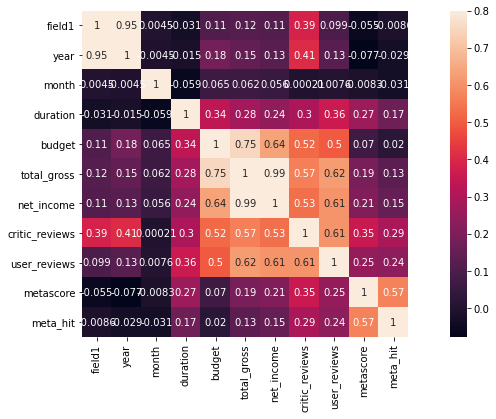

In [4]:
# plot a sns heat map to see what data correlates.
plt.figure(figsize=(18,8),dpi=100,)
plt.subplots(figsize=(15,6))
sns.heatmap(data=imdb_df.corr(),square=True,vmax=0.8,annot=True)

# Critically Acclaimed Movies (Based off of Metascore)

Our group considers a movie to be critically acclaimed (meta_hit) if the movie achieves a metascore of 75 or greater.

### Split data into training and testing

In [5]:
# seperate the features(X) from the target (y)
y = imdb_df['meta_hit']
X = pd.get_dummies(imdb_df.drop(columns='meta_hit'))

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify = y)
X_train.shape

(2498, 3925)

### Create a MetaHit Logistic Regression Model

In [6]:
classifier = LogisticRegression(solver='lbfgs', max_iter = 200, random_state = 1)

In [7]:
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

### Make Predictions

In [8]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)

In [9]:
results.head(20)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,1
8,0,0
9,0,0


In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8955582232893158


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, y_pred)
# create a dataframe from the confusion matrix
matrix_df = pd.DataFrame(matrix, index=['Actual Critical Hit', 'Actual Non-Critical Hit'], columns=['Predicted Critical Hit', 'Predicted Non-Critical Hit'])
matrix_df

,Predicted Critical Hit,Predicted Non-Critical Hit
Actual Critical Hit,744,3
Actual Non-Critical Hit,84,2


In [12]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       747
           1       0.40      0.02      0.04        86

    accuracy                           0.90       833
   macro avg       0.65      0.51      0.49       833
weighted avg       0.85      0.90      0.85       833



# Blockbuster movies

Our group considers a blockbuster movie by two stipulations:

1. A movie with a budget less than 7 million and having a gross profit greater than or equal to 500 percent.
2. A movie with a budget over 7 million and having a gross profit greater than or equal to 250 percent.

In [13]:
# create a new gross profit column using the Gross profit margin formula 

# Gross Profit Margin = (Revenue – Cost) / Revenue x 100
imdb_df['gross_profit'] = (imdb_df['total_gross'] - imdb_df['budget'])/imdb_df['budget'] * 100

# create new blockbuster column
imdb_df['blockbuster'] = 0
imdb_df.head()

,field1,title,year,month,genre,duration,country,language,budget,total_gross,net_income,critic_reviews,user_reviews,metascore,meta_hit,gross_profit,blockbuster
0,4334,Kate & Leopold,2001,3,"Comedy, Fantasy, Romance",118,USA,"English, French",48000000,76019048,28019048,115.0,341.0,44.0,0,58.373017,0
1,19759,Diritto di cronaca,1981,3,"Drama, Romance, Thriller",116,USA,"English, Spanish",12000000,40716963,28716963,27.0,115.0,64.0,0,239.308025,0
2,19774,Arturo,1981,2,"Comedy, Romance",97,USA,English,7000000,95461682,88461682,44.0,132.0,69.0,0,1263.738314,0
3,19790,Blow Out,1981,4,"Crime, Drama, Mystery",108,USA,English,18000000,12000000,-6000000,123.0,199.0,86.0,1,-33.333333,0
4,19804,Libertà poco vigilata,1981,5,"Comedy, Drama",94,USA,English,11000000,31261269,20261269,5.0,16.0,55.0,0,184.193355,0


In [14]:
# split the budget data 
BBmovie_lower = imdb_df[imdb_df['budget']<7000000]
BBmovie_over = imdb_df[imdb_df['budget']>7000000]

# Set the blockbuster conditions
BBmovie_lower['blockbuster'] = BBmovie_lower['gross_profit'].apply(lambda x: 1 if x>=500 else 0)
BBmovie_over['blockbuster'] = BBmovie_over['gross_profit'].apply(lambda x: 1 if x>=250 else 0)

In [15]:
# look at blockbuster counts below a $7,000,000 budget
BBmovie_lower.groupby('blockbuster')['blockbuster'].count()

blockbuster
0    664
1    159
Name: blockbuster, dtype: int64

In [16]:
# look at blockbuster counts over a $7,000,000 budget
BBmovie_over.groupby('blockbuster')['blockbuster'].count()

blockbuster
0    1812
1     641
Name: blockbuster, dtype: int64

In [17]:
# combine lower and over into imdb dataframe
imdb_df = pd.concat([BBmovie_lower, BBmovie_over])
imdb_df.head()

,field1,title,year,month,genre,duration,country,language,budget,total_gross,net_income,critic_reviews,user_reviews,metascore,meta_hit,gross_profit,blockbuster
5,19837,Alla maniera di Cutter,1981,2,"Crime, Drama, Mystery",109,USA,English,3000000,1752634,-1247366,43.0,60.0,70.0,0,-41.578867,0
6,19847,Benedizione mortale,1981,8,"Horror, Thriller",100,USA,English,2500000,8279042,5779042,114.0,73.0,56.0,0,231.161680,0
8,19883,1997: fuga da New York,1981,10,"Action, Adventure, Sci-Fi",99,USA,English,6000000,25244626,19244626,250.0,343.0,76.0,1,320.743767,0
11,19918,L'assassino ti siede accanto,1981,4,"Horror, Mystery, Thriller",87,USA,English,1250000,21722776,20472776,165.0,437.0,26.0,0,1637.822080,1
12,19947,Il signore della morte,1981,10,Horror,92,USA,English,2500000,25533818,23033818,197.0,561.0,40.0,0,921.352720,1


### Split the data into training and testing

In [18]:
# seperate the features(X) from the target (y)
y = imdb_df['blockbuster']
X = pd.get_dummies(imdb_df.drop(columns='blockbuster'))

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify = y)
X_train.shape

(2457, 3866)

In [19]:
# Check the balance of our target values
y.value_counts()

0    2476
1     800
Name: blockbuster, dtype: int64

### Create a Logistic Regression Model for Blockbuster Movies

In [20]:
classifier = LogisticRegression(solver='lbfgs', max_iter = 200, random_state = 1)

In [21]:
# Fit (train) the model using the training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

### Make Predictions

In [22]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,1
8,0,0
9,0,0


In [23]:
# Calculate the balanced accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9682539682539683


In [24]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, y_pred)

# create a dataframe from the confusion matrix
matrix_df = pd.DataFrame(matrix, index=['Actual Blockbuster Hit', 'Actual Non-Blockbuster'], columns=['Predicted Blockbuster Hit', 'Predicted Non-Blockbuster'])
matrix_df

,Predicted Blockbuster Hit,Predicted Non-Blockbuster
Actual Blockbuster Hit,613,6
Actual Non-Blockbuster,20,180


In [25]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       619
           1       0.97      0.90      0.93       200

    accuracy                           0.97       819
   macro avg       0.97      0.95      0.96       819
weighted avg       0.97      0.97      0.97       819

